# Expérience 5.5 (papier) + extension gradients + extension Contextual Flow ( fashion - MNIST)

Ici, on reproduit l’expérience 5.5 du papier : on suit l’évolution des **gaps d’inférence** pendant l’entraînement, sur un petit subset **train** et **validation**, à plusieurs checkpoints (25, 50, 100, 250 époques), pour plusieurs variantes (Gaussian, Flow, ContextualFlow, Large Encoder, Large Decoder).

À chaque checkpoint, on estime $\log \hat p(x)$ (IWAE + parfois AIS), $\mathcal{L}[q]$ (encodeur amorti) et $\mathcal{L}[q^*]$ (optimisation locale), puis on en déduit :
- approximation gap : $$\log \hat p(x) - \mathcal{L}[q^*]$$
- amortization gap : $$\mathcal{L}[q^*] - \mathcal{L}[q]$$

En plus, on ajoute notre extension : on enregistre pendant l’entraînement les normes de gradients de l’encodeur et du décodeur, et on regarde leur ratio $\|\nabla_{enc}\| / \|\nabla_{dec}\|$ (aussi en version normalisée par $\sqrt{N}$ car les modèles n’ont pas la même taille).

Ce qu’on observe typiquement :
- le **gap d’amortization** s’ouvre plus sur la validation (l’encodeur généralise moins bien),
- le warm-up KL crée un pic au début (l’encodeur prend plus de “pression”),
- les flows donnent souvent une dynamique plus “équilibrée” (ratio plus bas) que le Gaussian simple.

# Import 


In [1]:
import os, sys, numpy as np, time, math
from pathlib import Path
import torch
from torch import nn 
import torch, torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt
import csv
import pandas as pd 

base_dir = Path.cwd().parent
sys.path.insert(0, str(base_dir / 'models'))
sys.path.insert(0, str(base_dir / 'models' / 'utils'))


from vae_2 import VAE
from inference_net import standard
from distributions import Gaussian, Flow, ContextualFlow
from optimize_local_q import optimize_local_q_dist
from ais3 import test_ais

# Dataset and Device


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}')



npz_path = 'fashion_mnist.npz'  
data = np.load(npz_path)
print("Clés:", data.files)

train_data = data['X_train']

test_data  = data['X_test']
print(f"Train: {train_data.shape}, Test: {test_data.shape}")


train_x = train_data           
eval_x  = test_data       
x_size, z_size = train_x.shape[1], 50


Device: mps
Clés: ['X_train', 'y_train', 'X_test', 'y_test']
Train: (60000, 784), Test: (10000, 784)


# Fonctions utiles pour calcul des gaps, définitions des modèles, sauvegarde des modèles.


In [ ]:
def train_step_with_loss_tracking(model, X, opt, warmup_T=50.0, total_epochs=0, batch_size=64):
    X_t = torch.from_numpy(X).float()
    y = torch.zeros(len(X))
    loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_t, y), batch_size=batch_size, shuffle=True)

    # On va suivre la norme des gradients et aussi les termes KL / reconstruction.
    grad_norms_enc, grad_norms_dec = [], []
    total_kl, total_recon = 0.0, 0.0
    n_batches = 0

    for xb, _ in loader:
        xb = xb.to(device)
        opt.zero_grad()

        # On applique un warm-up du KL : au début warm≈0, puis ça monte jusqu’à 1.
        warm = min(total_epochs / warmup_T, 1.0) 
        
        # forward3 renvoie ELBO + (recon, KL) pour qu’on puisse logger proprement.
        elbo, recon_loss, kl_loss = model.forward3(xb, k=1, warmup=warm, return_components=True)
        (-elbo).backward()

        # On calcule la norme L2 des gradients côté encodeur et côté décodeur.
        enc_grads = [p.grad for p in model.q_dist.parameters() if p.grad is not None]
        dec_grads = [p.grad for p in model.generator.parameters() if p.grad is not None]
        enc_norm = torch.sqrt(sum(torch.sum(g**2) for g in enc_grads)) if enc_grads else torch.tensor(0.)
        dec_norm = torch.sqrt(sum(torch.sum(g**2) for g in dec_grads)) if dec_grads else torch.tensor(0.)

        # On fait un pas d’optimisation et on stocke les stats de ce batch.
        opt.step()
        grad_norms_enc.append(enc_norm.item())
        grad_norms_dec.append(dec_norm.item())
        total_kl += kl_loss.item()
        total_recon += recon_loss.item()
        n_batches += 1

    # On moyenne sur tous les batches de l’époque.
    mean_enc_grad = np.mean(grad_norms_enc)
    mean_dec_grad = np.mean(grad_norms_dec)
    mean_kl = total_kl / n_batches
    mean_recon = total_recon / n_batches

    return elbo.item(), mean_enc_grad, mean_dec_grad, mean_kl, mean_recon


def train_model_with_tracking(model, X, opt, start_epoch_global, max_epochs_global, batch_size=64):
    # On stocke l’historique pour pouvoir tracer ensuite 
    grad_history, kl_history, recon_history = [], [], []

    # On entraîne de start_epoch_global+1 jusqu’à max_epochs_global
    for ep_global in range(start_epoch_global + 1, max_epochs_global + 1):
        
        # On passe ep_global dans total_epochs pour que le warm-up soit cohérent si on reprend un run.
        elbo_val, grad_enc, grad_dec, kl, recon = train_step_with_loss_tracking(
            model, X, opt, 
            total_epochs=ep_global, 
            batch_size=batch_size
        )

        # On log les valeurs moyennes de cette époque.
        grad_history.append((ep_global, grad_enc, grad_dec))
        kl_history.append((ep_global, kl))
        recon_history.append((ep_global, recon))
        
        # Petit print régulier pour suivre l’entraînement.
        if ep_global % 50 == 0:
            print(f"   [train] epoch {ep_global}/{max_epochs_global} ELBO={elbo_val:.2f} | KL={kl:.2f} | recon={recon:.2f} | grad_enc={grad_enc:.2e} | grad_dec={grad_dec:.2e}")

    return grad_history, kl_history, recon_history


def save_weights(model, tag, out_dir):
    # On sauvegarde séparément l’encodeur et le décodeur pour pouvoir reprendre / comparer.
    enc_p = out_dir / f"encoder_{tag}.pt"
    dec_p = out_dir / f"decoder_{tag}.pt"
    torch.save(model.q_dist.state_dict(), enc_p)
    torch.save(model.generator.state_dict(), dec_p)
    return enc_p, dec_p


def load_weights(model, enc_p, dec_p):
    # On recharge les poids puis on passe le modèle en eval (utile pour l’évaluation des gaps).
    model.q_dist.load_state_dict(torch.load(enc_p, map_location=device))
    model.generator.load_state_dict(torch.load(dec_p, map_location=device))
    model.eval()


def evaluate_gaps_on_subset(model, data, split_name):
    # On calcule log p(x) (via IWAE), puis L[q] (amorti) et L[q*] (optim local).
    logp = logp_iwae(model, data, K=5000, batch_size=100)
    Lq = amortized_elbo(model, data, batch_size=100)
    Lq_star = locally_optimized_elbo(model, data, n_points=50) 

    # On en déduit approximation / amortization / inference gap.
    approx_gap = logp - Lq_star
    amort_gap  = Lq_star - Lq
    infer_gap  = logp - Lq

    print(f"   [{split_name}] logp={logp:.2f} | Lq*={Lq_star:.2f} | Lq={Lq:.2f}")
    return logp, Lq, Lq_star, approx_gap, amort_gap, infer_gap


@torch.no_grad()
def amortized_elbo(model, X, k=1, batch_size=100):
    # ELBO amorti : on utilise directement l’encodeur entraîné du modèle.
    vals = []
    loader = torch.utils.data.DataLoader(torch.from_numpy(X).float(), batch_size=batch_size, shuffle=False)
    for xb in loader:
        xb = xb.to(device)
        elbo, _, _ = model.forward(xb, k=k, warmup=1.0)
        vals.append(elbo.item())
    return float(np.mean(vals))


def locally_optimized_elbo(model, X, n_points=10):
    # ELBO "oracle" : on repart du même type de q que le modèle, puis on l’optimise localement par point.
    vals = []

    q_class = type(model.hyper_params['q'])
    
    for i in range(min(n_points, len(X))):
        x = torch.from_numpy(X[i]).float().view(1,-1).to(device)
        logpost = lambda z: model.logposterior_func2(x=x, z=z)

        # On instancie q_local (même famille : Gaussian / Flow / ContextualFlow).
        q_local = q_class(model.hyper_params).to(device)
        
        # On warm-start avec les poids du q amorti quand c’est possible
        try:
            q_local.load_state_dict(model.hyper_params['q'].state_dict())
        except Exception as e:
            pass 

        # On optimise q_local sur CE point (x) seulement, avec le décodeur fixé.
        vae_star, _ = optimize_local_q_dist(logpost, model.hyper_params, x, q_local)
        vals.append(float(vae_star.item()))
        
    return float(np.mean(vals))


@torch.no_grad()
def logp_iwae(model, X, K=500, batch_size=100):
    # IWAE : approximation de log p(x) 
    vals = []
    loader = torch.utils.data.DataLoader(torch.from_numpy(X).float(), batch_size=batch_size, shuffle=False)
    for xb in loader:
        xb = xb.to(device)
        iwaeK, _, _ = model.forward2(xb, k=K)
        vals.append(iwaeK.item())
    return float(np.mean(vals))


def estimate_logp_per_model_AIS(model, X, K=50, n_intermediate=200, batch_size=25):
    """Estime log p(x) via AIS (moyenne sur X)."""
    model.eval()
    N = X.shape[0]
    out_vals = []
    for i in range(0, N, batch_size):
        xb = X[i:i+batch_size]
        if not isinstance(xb, np.ndarray):
            xb = xb.detach().cpu().numpy()
        try:
            est = test_ais(model=model, data_x=xb, batch_size=xb.shape[0],
                           display=0, k=K, n_intermediate_dists=n_intermediate)
            if torch.is_tensor(est):
                est = est.item()
            out_vals.append(float(est))
        except Exception as e:
            print(f" AIS batch {i//batch_size+1} failed: {e}")
    return float(np.mean(out_vals)) if out_vals else float('nan')


def build_model(q_class, variant='standard', x_size=784, z_size=50, hnf_flag=False):
    # On construit un VAE selon la famille q(z|x)
    context_size = 0
    if q_class is ContextualFlow:
        context_size = 128

    output_size = 2 * z_size
    if context_size > 0:
        output_size += context_size

    # Variante "large decoder" : on boost le décodeur.
    if variant == 'large_decoder':
        enc_arch = [[x_size,200],[200,200],[200, output_size]] 
        dec_arch = [[z_size,500],[500,500],[500,500],[500,x_size]]
        act = F.elu

    # Variante "large encoder" : on boost l’encodeur.
    elif variant == 'large_encoder':
        enc_arch = [[x_size, 500], [500, 500], [500, 500], [500, output_size]] 
        dec_arch = [[z_size, 200], [200, 200], [200, x_size]]
        act = F.elu

    # Variante standard : encodeur plus simple.
    else:
        if q_class is ContextualFlow:
            enc_arch = [[x_size,100],[100, output_size]]
        else:
            enc_arch = [[x_size,200],[200,200],[200, output_size]]
             
        dec_arch = [[z_size,200],[200,200],[200,x_size]]
        act = F.tanh

    hyper = {
        'x_size': x_size, 'z_size': z_size, 'act_func': act,
        'encoder_arch': enc_arch, 'decoder_arch': dec_arch,
        'q_dist': standard,
        'cuda': int(device.type=='cuda'),
        'hnf': int(hnf_flag),
        'context_size': context_size
    }

    # On instancie la distribution q (Gaussian / Flow / ContextualFlow).
    q = q_class(hyper) 
    hyper['q'] = q 

    # On crée le VAE complet.
    m = VAE(hyper).to(device) 
    m.hyper_params = hyper
    return m, hyper


# On fixe des subsets train/eval pour mesurer les gaps toujours sur les mêmes points.
n = 15 
rng = np.random.default_rng(0)
idx_train_subset = rng.choice(len(train_x), size=n, replace=False)
idx_eval_subset  = rng.choice(len(eval_x), size=n, replace=False)
train_subset = train_x[idx_train_subset]
eval_subset  = eval_x[idx_eval_subset]


def evaluate_with_AIS(model, data, split_name, batch_size=n):
    # On calcule IWAE et AIS, puis on garde le meilleur des deux (logp_used).
    logp_iwae_val = logp_iwae(model, data, K=10000, batch_size=batch_size)
    try:
        logp_ais_val = estimate_logp_per_model_AIS(model, data, K=100, n_intermediate=200, batch_size=batch_size)
    except Exception as e:
        print(f" AIS échoué ({split_name}): {e}")
        logp_ais_val = np.nan

    logp_used = max(logp_iwae_val, logp_ais_val) if not np.isnan(logp_ais_val) else logp_iwae_val

    # On calcule L[q] et L[q*] sur ce split.
    Lq = amortized_elbo(model, data, batch_size=batch_size)
    Lq_star = locally_optimized_elbo(model, data, n_points=batch_size) 

    # Puis les gaps.
    approx_gap = logp_used - Lq_star
    amort_gap  = Lq_star - Lq
    infer_gap  = logp_used - Lq

    print(f"[{split_name}] logp_IWAE={logp_iwae_val:.2f} | logp_AIS={logp_ais_val:.2f} | "
          f"Lq*={Lq_star:.2f} | Lq={Lq:.2f} | approx={approx_gap:.2f} | amort={amort_gap:.2f}")
    return logp_iwae_val, logp_ais_val, logp_used, Lq, Lq_star, approx_gap, amort_gap, infer_gap

# Run de l'expérience

In [ ]:
families = {
    # On définit les 5 configurations qu’on veut comparer (même boucle pour tout le monde).
    # Chaque entrée = (classe de q, flag HNF, variante d’archi).
    'Gaussian':        (Gaussian, False, 'standard'),
    'Flow':            (Flow,   False, 'standard'),
    'ContextualFlow':  (ContextualFlow, False, 'standard'),
    'Gaussian_LargeD': (Gaussian, False, 'large_decoder'),
    'Gaussian_LargeE': (Gaussian, False, 'large_encoder')
}


# On fixe les époques auxquelles on veut regarder le modèle
epoch_checkpoints = [25, 50, 100, 250] 

# Dossier où on stocke les checkpoints + les CSV de résultats.
results_dir = Path("exp55_run_corrigé_fashion") 
results_dir.mkdir(exist_ok=True)

csv_path = results_dir / "gaps_gradients_ais_fashion.csv"
grad_hist_path = results_dir / "grad_history_fashion.csv"


# On crée le CSV des gaps (une ligne par split train/eval et par checkpoint).
if not csv_path.exists():
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            "epoch", "family", "variant", "split",
            "logp_iwae", "logp_ais", "logp_used",
            "Lq", "Lq_star",
            "approx_gap", "amort_gap", "infer_gap",
            "grad_norm_enc", "grad_norm_dec"
        ])

# On crée aussi un CSV séparé pour logger les gradients / KL / recon au fil des époques.
if not grad_hist_path.exists():
    with open(grad_hist_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["family", "variant", "epoch", "grad_norm_enc", "grad_norm_dec", "kl_loss", "recon_loss"])


batch_size = 64
lr = 1e-3 

# Boucle principale : on entraîne / évalue chaque famille de modèle.
for name, (q_class, hnf_flag, variant) in families.items():
    print(f"\n🔹 Famille {name} — variante {variant}")

    # On construit le modèle avec la bonne famille de posterior et la bonne taille d’archi.
    model, hyper = build_model(q_class, variant=variant, hnf_flag=hnf_flag)
    model.to(device)

    # on crée l’optimiseur une seule fois, puis on le recharge si on reprend un checkpoint.
    opt = optim.Adam(list(model.q_dist.parameters()) + list(model.generator.parameters()), lr=lr)

    # Pour chaque checkpoint, soit on charge (si déjà entraîné), soit on continue l’entraînement.
    for ep in epoch_checkpoints:
        enc_path = results_dir / f"encoder_{name}_{variant}_ep{ep}.pt"
        dec_path = results_dir / f"decoder_{name}_{variant}_ep{ep}.pt"

        # On regarde jusqu’à quelle époque on a déjà des checkpoints sur disque.
        prev_epochs = sorted([int(p.stem.split('_ep')[-1]) for p in results_dir.glob(f"encoder_{name}_{variant}_ep*.pt")])
        start_epoch = prev_epochs[-1] if prev_epochs else 0

        # Si le checkpoint existe déjà, on charge et on évite de ré-entraîner.
        if start_epoch >= ep:
            load_weights(model, enc_path, dec_path)
            print(f" Modèle {name} ({variant}) déjà à epoch {ep}.")
        
        # Sinon, on reprend depuis le dernier checkpoint disponible, ou bien on part de zéro.
        else:
            if start_epoch > 0:
                last_enc = results_dir / f"encoder_{name}_{variant}_ep{start_epoch}.pt"
                last_dec = results_dir / f"decoder_{name}_{variant}_ep{start_epoch}.pt"
                opt_path = results_dir / f"optimizer_{name}_{variant}_ep{start_epoch}.pt"
                
                load_weights(model, last_enc, last_dec)

                # On recharge aussi l’optimiseur pour avoir une reprise propre (mêmes moments, mêmes moments).
                if opt_path.exists():
                    opt.load_state_dict(torch.load(opt_path, map_location=device))
                
                print(f" Reprise de {start_epoch} → {ep} pour {name} ({variant})")
            else:
                print(f" Entraînement {name} ({variant}) depuis zéro jusqu’à {ep}")

            # Entraînement entre start_epoch et ep, en loggant les gradients + KL/recon.
            grad_history, kl_hist, recon_hist = train_model_with_tracking(
                model, train_x, opt,
                start_epoch_global=start_epoch, 
                max_epochs_global=ep, 
                batch_size=batch_size
            )

            # On sauvegarde les poids à ce checkpoint.
            save_weights(model, f"{name}_{variant}_ep{ep}", results_dir)

            # On sauvegarde aussi l’état de l’optimiseur
            torch.save(opt.state_dict(), results_dir / f"optimizer_{name}_{variant}_ep{ep}.pt")

            # On écrit dans le CSV l’historique de gradients
            for i, (e_global, genc, gdec) in enumerate(grad_history):
                kl_val = kl_hist[i][1] if i < len(kl_hist) else np.nan
                rec_val = recon_hist[i][1] if i < len(recon_hist) else np.nan
                with open(grad_hist_path, 'a', newline='') as f:
                    csv.writer(f).writerow([name, variant, e_global, genc, gdec, kl_val, rec_val])

        # Évaluation à la fin de chaque checkpoint sur train_subset et eval_subset 
        results = []
        for split_name, data in [('train', train_subset), ('eval', eval_subset)]:
            logp_iwae_val, logp_ais_val, logp_used, Lq, Lq_star, approx_gap, amort_gap, infer_gap = evaluate_with_AIS(
                model, data, split_name, batch_size=n #
            )
            results.append([
                ep, name, variant, split_name,
                logp_iwae_val, logp_ais_val, logp_used,
                Lq, Lq_star,
                approx_gap, amort_gap, infer_gap
            ])

        # On écrit les résultats de ce checkpoint dans le CSV principal.
        with open(csv_path, 'a', newline='') as f:
            csv.writer(f).writerows(results)

print("\n Tous les modèles et résultats enregistrés :", csv_path)

# Plot des résultats

## Plot des Gaps durant le training sur la base de train et de test

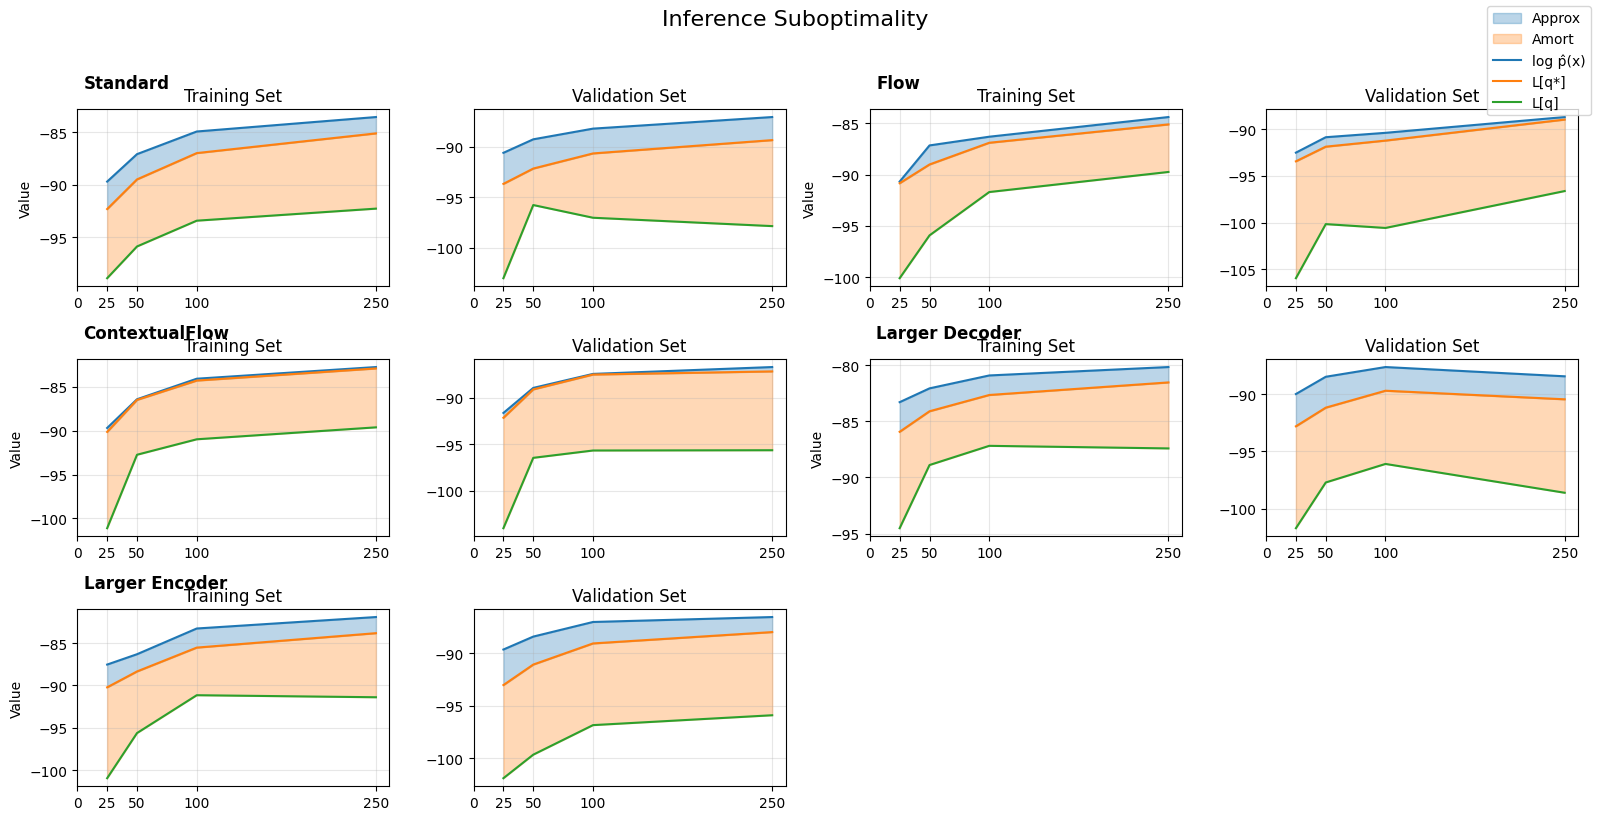

In [16]:
base = Path("exp55_run_corrigé_fashion/")  
df = pd.read_csv(base / "gaps_gradients_ais_fashion.csv") 

df = df[[
    "epoch", "family", "variant", "split",
    "logp_used", "Lq", "Lq_star"
]]

df["epoch"] = df["epoch"].astype(float) 

families = [
    ("Gaussian", "Standard"),
    ("Flow", "Flow"),
    ("ContextualFlow", "ContextualFlow"),
    ("Gaussian_LargeD", "Larger Decoder"),
    ("Gaussian_LargeE", "Larger Encoder")
]


rows, cols = 3, 4
fig = plt.figure(figsize=(16, 8), facecolor='white')
plt.subplots_adjust(wspace=0.25, hspace=0.35)  

col_logp = "#1f77b4"  # log p̂(x)
col_Lqs  = "#ff7f0e"  # L[q*]
col_Lq   = "#2ca02c"  # L[q]


for idx, (fam, title) in enumerate(families):


    df_f = df[df["family"] == fam].copy()
    
    # Chaque famille a deux plots : train et eval.
    splits = ["train", "eval"]
    
    row = idx // 2     
    col = (idx % 2)*2  

    for j, split in enumerate(splits):

        # On filtre sur le split et on trie par epoch 
        df_s = df_f[df_f["split"] == split].sort_values("epoch")

        # On récupère les séries qu’on veut tracer.
        epochs = df_s["epoch"].values
        logp   = df_s["logp_used"].values
        Lqs    = df_s["Lq_star"].values
        Lq     = df_s["Lq"].values
        

        ax = plt.subplot2grid((rows, cols), (row, col + j))

        if split == "train":
            ax.set_title(f"Training Set", fontsize=12)
        else:
            ax.set_title(f"Validation Set", fontsize=12)

        # On met le nom du modèle au-dessus de la colonne train
        if split == "train":
            ax.text(0.02, 1.12, title, transform=ax.transAxes,
                    fontsize=12, weight='bold')

        # Aires colorées :
        # - bleu : approximation gap = logp - L[q*]
        # - orange : amortization gap = L[q*] - L[q]
        ax.fill_between(epochs, logp, Lqs, color=col_logp, alpha=0.3, label="Approx")
        ax.fill_between(epochs, Lqs, Lq , color=col_Lqs,  alpha=0.3, label="Amort")

        # Courbes principales : logp, L[q*], L[q].
        ax.plot(epochs, logp, color=col_logp, label="log p̂(x)")
        ax.plot(epochs, Lqs,  color=col_Lqs,  label="L[q*]")
        ax.plot(epochs, Lq,   color=col_Lq,   label="L[q]")

        ax.set_xticks([0, 25, 50, 100, 250])

        ax.grid(True, alpha=0.3)

        if j == 0:
            ax.set_ylabel("Value")


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", fontsize=10)


plt.suptitle("Inference Suboptimality", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Plots des gradients durant le training et termes KL et de reconstruction.

grad_history : (1250, 7), gaps_gradients_ais : (40, 14)


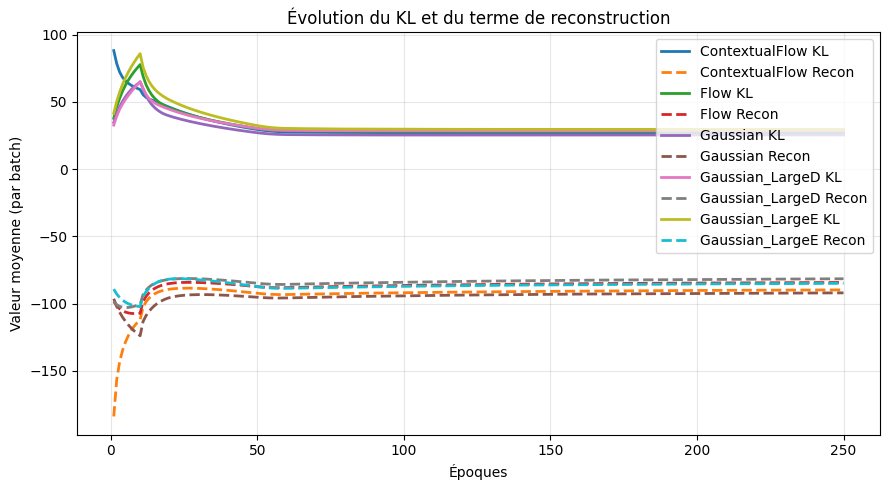

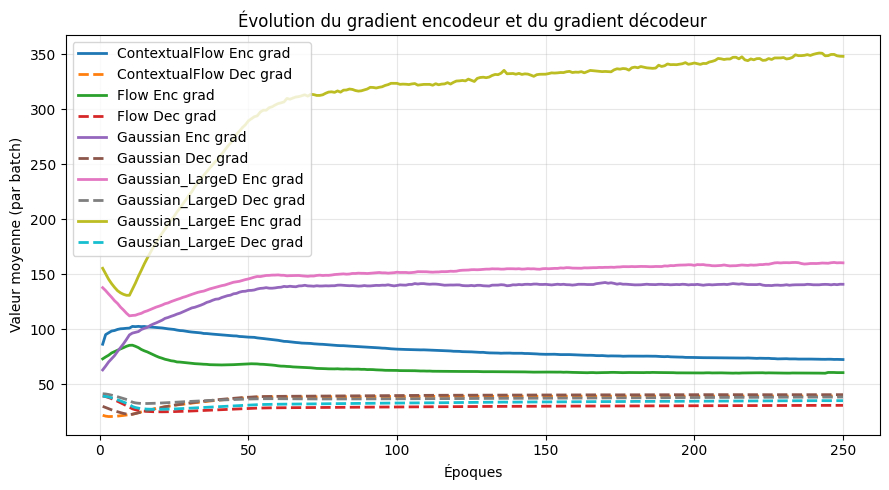

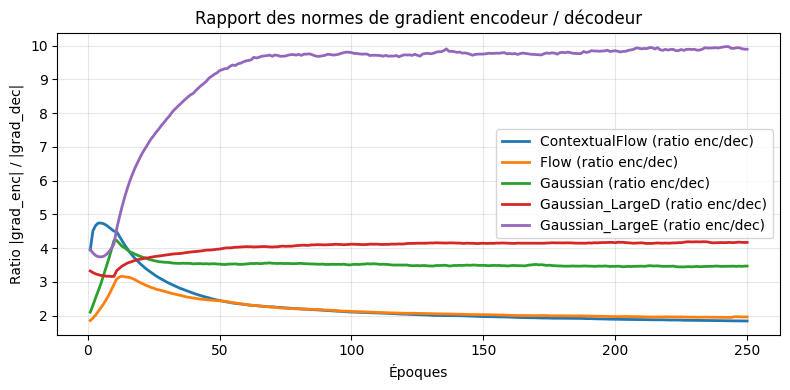

In [ ]:
base = Path("exp55_run_corrigé_fashion")  
df_grad = pd.read_csv(base / "grad_history_fashion.csv")  # On charge l’historique des gradients + KL/recon (par epoch)
df_gap  = pd.read_csv(base / "gaps_gradients_ais_fashion.csv") 

print(f"grad_history : {df_grad.shape}, gaps_gradients_ais : {df_gap.shape}")  


df_grad = df_grad.sort_values(["family", "epoch"])
df_gap = df_gap.sort_values(["family", "epoch", "split"])


win = 10  # On choisit une fenêtre simple pour lisser un peu (moyenne glissante)
for col in ["grad_norm_enc", "grad_norm_dec", "kl_loss", "recon_loss"]:
    if col in df_grad.columns:
        # On crée une version “smooth” pour voir la tendance sans trop de bruit
        df_grad[f"{col}_smooth"] = df_grad[col].rolling(win, min_periods=1).mean()


# 1) Courbes KL vs reconstruction 
plt.figure(figsize=(9,5))
for fam in df_grad["family"].unique():
    sub = df_grad[df_grad["family"] == fam]  # On isole une famille
    plt.plot(sub["epoch"], sub["kl_loss_smooth"], label=f"{fam} KL", linewidth=2)  # Courbe KL
    plt.plot(sub["epoch"], sub["recon_loss_smooth"], "--", label=f"{fam} Recon", linewidth=2)  # Courbe recon
plt.xlabel("Époques")
plt.ylabel("Valeur moyenne (par batch)")
plt.title("Évolution du KL et du terme de reconstruction")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 2) Normes de gradient encodeur vs décodeur (lissées)
plt.figure(figsize=(9,5))
for fam in df_grad["family"].unique():
    sub = df_grad[df_grad["family"] == fam]  # On isole une famille
    plt.plot(sub["epoch"], sub["grad_norm_enc_smooth"], label=f"{fam} Enc grad", linewidth=2)  # Grad encodeur
    plt.plot(sub["epoch"], sub["grad_norm_dec_smooth"], "--", label=f"{fam} Dec grad", linewidth=2)  # Grad décodeur
plt.xlabel("Époques")
plt.ylabel("Valeur moyenne (par batch)")
plt.title("Évolution du gradient encodeur et du gradient décodeur")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 3) Ratio enc/dec, pression encodeur vs pression décodeur”
plt.figure(figsize=(8,4))
for fam in df_grad["family"].unique():
    sub = df_grad[df_grad["family"] == fam]  # On isole une famille
    ratio = sub["grad_norm_enc_smooth"] / sub["grad_norm_dec_smooth"]  # Ratio lissé enc/dec
    plt.plot(sub["epoch"], ratio, label=f"{fam} (ratio enc/dec)", linewidth=2)
plt.xlabel("Époques")
plt.ylabel("Ratio |grad_enc| / |grad_dec|")
plt.title("Rapport des normes de gradient encodeur / décodeur")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Evaluation du nombre de paramètres

In [18]:
families = {
    'Gaussian':        (Gaussian, False, 'standard'),
    'Flow':            (Flow,   False, 'standard'),
    'ContextualFlow':  (ContextualFlow, False, 'standard'),
    'Gaussian_LargeD': (Gaussian, False, 'large_decoder'),
    'Gaussian_LargeE': (Gaussian, False, 'large_encoder')
}

def count_params(module: nn.Module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

def count_encoder_decoder_params(q_class, variant):
    model, hyper = build_model(q_class, variant=variant)
    enc_params = count_params(model.q_dist)
    dec_params = count_params(model.generator)
    total = enc_params + dec_params
    return enc_params, dec_params, total


results_param_counts = []

for name, (q_class, hnf_flag, variant) in families.items():
    enc, dec, tot = count_encoder_decoder_params(q_class, variant)
    results_param_counts.append({
        "family": name,
        "variant": variant,
        "encoder_params": enc,
        "decoder_params": dec,
        "total_params": tot
    })

import pandas as pd
df_params = pd.DataFrame(results_param_counts)
print(df_params)

            family        variant  encoder_params  decoder_params  \
0         Gaussian       standard          217300          207984   
1             Flow       standard          258100          207984   
2   ContextualFlow       standard          265128          207984   
3  Gaussian_LargeD  large_decoder          217300          919284   
4  Gaussian_LargeE  large_encoder          943600          207984   

   total_params  
0        425284  
1        466084  
2        473112  
3       1136584  
4       1151584  


## Plot normalisé pour prendre en compte le nombre de paramètres


=== PARAMETER COUNTS (sanity check) ===
('Gaussian', 'standard') {'enc_params': 217300, 'dec_params': 207984, 'sqrt_enc': 466.1544808322666, 'sqrt_dec': 456.0526285419261}
('Flow', 'standard') {'enc_params': 258100, 'dec_params': 207984, 'sqrt_enc': 508.0354318352215, 'sqrt_dec': 456.0526285419261}
('ContextualFlow', 'standard') {'enc_params': 265128, 'dec_params': 207984, 'sqrt_enc': 514.9058166305756, 'sqrt_dec': 456.0526285419261}
('Gaussian_LargeD', 'large_decoder') {'enc_params': 217300, 'dec_params': 919284, 'sqrt_enc': 466.1544808322666, 'sqrt_dec': 958.7929912134318}
('Gaussian_LargeE', 'large_encoder') {'enc_params': 943600, 'dec_params': 207984, 'sqrt_enc': 971.3907555664713, 'sqrt_dec': 456.0526285419261}


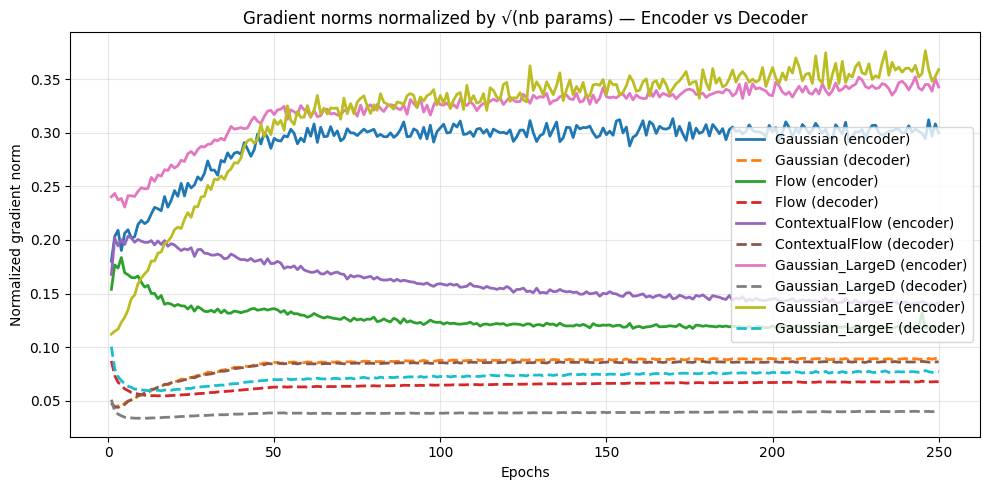

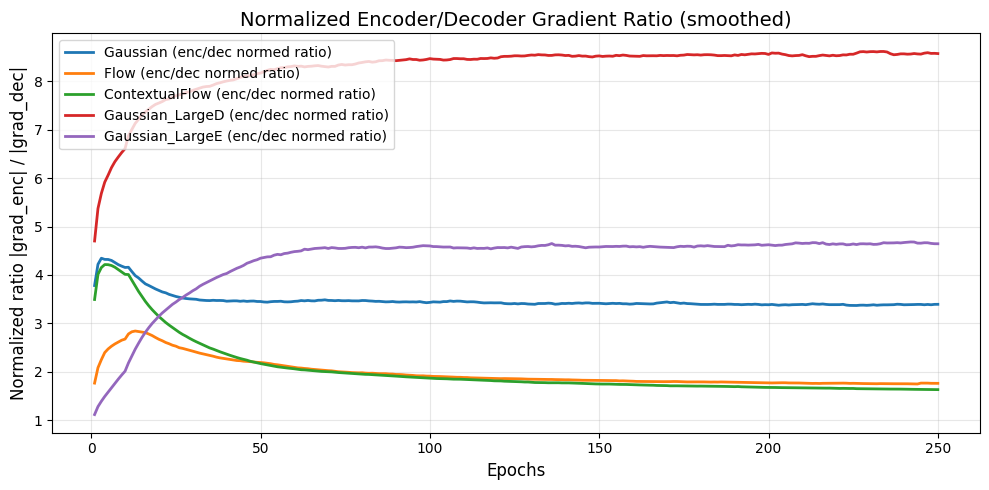

In [19]:
base = Path("exp55_run_corrigé_fashion/")
df_grad = pd.read_csv(base / "grad_history_fashion.csv")

df_grad["epoch"] = df_grad["epoch"].astype(float)

# On récupère les couples (family, variant) uniques pour reconstruire chaque architecture et compter ses paramètres
pairs = df_grad[["family", "variant"]].drop_duplicates()

def count_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

# On calcule une fois pour toutes le nb de paramètres (et √nb params) pour encoder / decoder, par modèle
param_stats = {}

for _, row in pairs.iterrows():
    fam = row["family"]
    var = row["variant"]

    if fam.startswith("Gaussian"):
        q_class = Gaussian
    elif fam.startswith("Flow"):
        q_class = Flow
    elif fam.startswith("ContextualFlow"):
        q_class = ContextualFlow
    else:
        raise ValueError(f"Unsupported family: {fam}")

    model, hyper = build_model(q_class, variant=var)
    enc = count_params(model.q_dist)
    dec = count_params(model.generator)

    param_stats[(fam, var)] = {
        "enc_params": enc,
        "dec_params": dec,
        "sqrt_enc": np.sqrt(enc),
        "sqrt_dec": np.sqrt(dec)
    }

print("\n=== PARAMETER COUNTS (sanity check) ===")
for k, v in param_stats.items():
    print(k, v)

# On normalise les normes de gradients par √(nb params) pour comparer des modules de tailles différentes
df_grad["grad_enc_normed"] = np.nan
df_grad["grad_dec_normed"] = np.nan

for idx, row in df_grad.iterrows():
    key = (row["family"], row["variant"])
    sqrtE = param_stats[key]["sqrt_enc"]
    sqrtD = param_stats[key]["sqrt_dec"]

    df_grad.loc[idx, "grad_enc_normed"] = row["grad_norm_enc"] / sqrtE
    df_grad.loc[idx, "grad_dec_normed"] = row["grad_norm_dec"] / sqrtD

plt.figure(figsize=(10,5))
for fam in df_grad["family"].unique():
    sub = df_grad[df_grad["family"] == fam].sort_values("epoch")
    plt.plot(sub["epoch"], sub["grad_enc_normed"], label=f"{fam} (encoder)", linewidth=2)
    plt.plot(sub["epoch"], sub["grad_dec_normed"], "--", label=f"{fam} (decoder)", linewidth=2)

plt.xlabel("Epochs")
plt.ylabel("Normalized gradient norm")
plt.title("Gradient norms normalized by √(nb params) — Encoder vs Decoder")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# On calcule le ratio enc/dec sur les gradients normalisés, puis on lisse pour voir la tendance
df_grad["ratio_normed"] = df_grad["grad_enc_normed"] / df_grad["grad_dec_normed"]

df_grad["ratio_normed_smooth"] = (
    df_grad.sort_values("epoch")
           .groupby(["family", "variant"])["ratio_normed"]
           .transform(lambda x: x.rolling(10, min_periods=1).mean())
)

plt.figure(figsize=(10,5))
for fam in df_grad["family"].unique():
    sub = df_grad[df_grad["family"] == fam].sort_values("epoch")
    plt.plot(sub["epoch"], sub["ratio_normed_smooth"],
             label=f"{fam} (enc/dec normed ratio)", linewidth=2)

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Normalized ratio |grad_enc| / |grad_dec|", fontsize=12)
plt.title("Normalized Encoder/Decoder Gradient Ratio (smoothed)", fontsize=14)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()